# Occupational Accident Mortality in Brazil from 2010 to 2022

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt

# Importing Data

Choosing the columns that will be used in the analysis

In [2]:
columns = ['DTOBITO','DTNASC','CAUSABAS','CODMUNOCOR','ACIDTRAB', 'OCUP', 'IDADE', 'SEXO']

Importing the datasets comprising the years 2010-2020

In [3]:
df = pd.concat([
    pd.read_csv(
        f"Data/{f}",
        sep=";",
        encoding="latin1",
        low_memory=False,
        usecols=columns,
        parse_dates=["DTOBITO", "DTNASC"],
        date_format="%d%m%Y"
    )
    for f in os.listdir("Data") if f.endswith(".csv")
])

Importing suplementar data to identify some columns of the main dataset

In [536]:
icd10codes = pd.read_csv('CID-10-SUBCATEGORIAS.CSV', delimiter=',', encoding='utf-8')
cbocodes = pd.read_csv('CBO2002.csv', delimiter=',', encoding='latin1', dtype='object')
statecode = pd.read_csv('DTB_BRASIL_MUNICIPIO.csv', encoding='latin1', usecols=['UF', 'Nome_UF'], dtype={'UF':'object'})
statepopulation = pd.read_csv('POP2022_Brasil_e_UFs.csv', encoding='utf-8').dropna()

# Filtering and tyding data

Filters the dataset to only show fatalities caused in work and individuals of all ages until 100 years old

In [608]:
work_accident = df.query("ACIDTRAB == 1 & 400 <= IDADE < 500").fillna('').dropna()

In [609]:
print(work_accident.duplicated().value_counts()) #checking for duplicates

False    45033
Name: count, dtype: int64


In [610]:
work_accident['SEXO'] = work_accident['SEXO'].map({0: 'Unknown', 1: 'Male', 2: 'Female', 9: 'Ignored'}) # creating categories for the genders

In [611]:
work_accident[['DTOBITO','DTNASC']] = work_accident[['DTOBITO','DTNASC']].apply(pd.to_datetime, format='%d%m%Y', errors='coerce') # transforming date data
work_accident['IDADE'] = work_accident['IDADE'].astype(int) # transforming age data to interger

Data in the columns below had to be sliced to pick only the part of the coding that are needed to merge with other tables or to show the actual number.

In [612]:
work_accident['OCUP'] = work_accident['OCUP'].astype(str).str.slice(stop=6)
work_accident['UF'] = work_accident['CODMUNOCOR'].astype(str).str.slice(stop=2)
work_accident['IDADE'] = work_accident['IDADE'].astype(str).str.slice(1).astype(int)
work_accident['ACIDTRAB'] = work_accident['ACIDTRAB'].astype(int)
work_accident['ANO'] = work_accident['DTOBITO'].dt.year
work_accident['MES'] = work_accident['DTOBITO'].dt.month

Map and organizes the Month column for better graph visualization

In [613]:
work_accident['MESNOME'] = work_accident['MES'].map({1: 'Jan',
                                                2: 'Feb', 
                                                3: 'Mar', 
                                                4: 'Apr', 
                                                5: 'May',
                                                6: 'Jun',
                                                7: 'Jul',
                                                8: 'Aug',
                                                9: 'Sep',
                                                10: 'Oct',
                                                11: 'Nov',
                                                12: 'Dec'
                                                })
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
work_accident['MESNOME'] = pd.Categorical(work_accident['MESNOME'], categories=months, ordered=True)

Merges the dataset with the supplementary data to show cause of the accident, profession, state name, and state population

In [614]:
work_accident = work_accident.merge(icd10codes,
                                    left_on='CAUSABAS',
                                    right_on='SUBCAT',
                                    how='left').merge(cbocodes,left_on='OCUP',
                                                      right_on='CODIGO',
                                                      how='left').merge(statecode,
                                                                        on='UF',
                                                                        how='left').merge(statepopulation,
                                                                                          left_on='Nome_UF',
                                                                                          right_on='UF',
                                                                                          how='left')

Drops doubled columns and change column names to english

In [615]:
work_accident = work_accident.drop(
    ['OCUP','CODMUNOCOR','DTOBITO', 'DTNASC','CAUSABAS','UF_x','UF_y'], axis=1).rename(
        columns={'TITULO':'PROFESSION', 
                 'Nome_UF':'STATE',
                 'IDADE':'AGE',
                 'DESCRICAO': 'ACCIDENT_DESCRIPTION',
                 'CODIGO' : 'ACCIDENT_CODE',
                 'SEXO' : 'SEX',
                 'ACIDTRAB': 'WORKACCIDENT',
                 'ANO': 'YEAR',
                 'MES': 'MONTH',
                 'MESNOME': 'MONTHNAME',
                 'POPULAÇÃO': 'POPULATION'
                })

In [616]:
bins = [0,19,59,100]
labels = ['Young','Adult', 'Elderly']
work_accident['AGE_RANGE'] = pd.cut(work_accident['AGE'], bins=bins, labels=labels, right=False) # create age categories

In [617]:
work_accident['POPULATION'] = work_accident['POPULATION'].str.replace(",", "").astype(int) # transforms the state population data column in integer

In [618]:
work_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45033 entries, 0 to 45032
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   AGE                   45033 non-null  int32   
 1   SEX                   45033 non-null  object  
 2   WORKACCIDENT          45033 non-null  int32   
 3   YEAR                  45033 non-null  int32   
 4   MONTH                 45033 non-null  int32   
 5   MONTHNAME             45033 non-null  category
 6   SUBCAT                45018 non-null  object  
 7   ACCIDENT_DESCRIPTION  45018 non-null  object  
 8   ACCIDENT_CODE         33816 non-null  object  
 9   PROFESSION            33816 non-null  object  
 10  STATE                 45033 non-null  object  
 11  POPULATION            45033 non-null  int32   
 12  AGE_RANGE             45033 non-null  category
dtypes: category(2), int32(5), object(6)
memory usage: 3.0+ MB


In [619]:
work_accident.head(10)

,AGE,SEX,WORKACCIDENT,YEAR,MONTH,MONTHNAME,SUBCAT,ACCIDENT_DESCRIPTION,ACCIDENT_CODE,PROFESSION,STATE,POPULATION,AGE_RANGE
0,27,Male,1,2010,3,Mar,W299,Contact with other hand items and household ap...,NaN,NaN,Acre,829780,Adult
1,42,Male,1,2010,4,Apr,W850,Exposure to electric power transmission lines ...,715615,Installation Electrician,Acre,829780,Adult
2,59,Male,1,2010,3,Mar,W139,Falling to or from buildings or other structur...,NaN,NaN,Acre,829780,Elderly
3,61,Female,1,2010,2,Feb,W209,"Impact caused by thrown, thrown or falling obj...",NaN,NaN,Acre,829780,Elderly
4,33,Male,1,2010,6,Jun,V899,Person injured in an accident with an unspecif...,NaN,NaN,Acre,829780,Adult
5,18,Male,1,2010,2,Feb,V845,Driver of a special motor vehicle for mainly a...,621005,Agricultural worker in general,Pernambuco,9051113,Young
6,21,Male,1,2010,1,Jan,V060,Pedestrian injured in collision with another n...,782310,Driver of a van or similar vehicle,Alagoas,3125254,Adult
7,40,Male,1,2010,4,Apr,W129,Falling onto or from a scaffold - location not...,715210,Mason,Alagoas,3125254,Adult
8,54,Male,1,2010,5,May,V952,Accident of another private-use fixed-wing air...,341120,Agricultural pilot,Alagoas,3125254,Adult
9,42,Male,1,2010,3,Mar,W205,"Impact caused by thrown, projected or falling ...",715210,Mason,São Paulo,46024937,Adult


# Data Analysis

### Yearly evaluation

Average Accidents by Month in Brazil from 2010-2022

In [620]:
accidents_months = work_accident.groupby(['MONTHNAME', 'YEAR'], observed=True)['WORKACCIDENT'].agg(['count'])
accidents_months = round(accidents_months.groupby('MONTHNAME', observed=True).mean(),0)

accidents_months['count'] = accidents_months['count'].apply(lambda x: int(x))
accidents_months

,count
MONTHNAME,
Jan,298
Feb,271
Mar,303
Apr,267
May,285
Jun,276
Jul,299
Aug,307
Sep,303


<Axes: title={'center': 'Average Accidents by month in Brazil between 2010 ad 2022'}, xlabel='Months'>

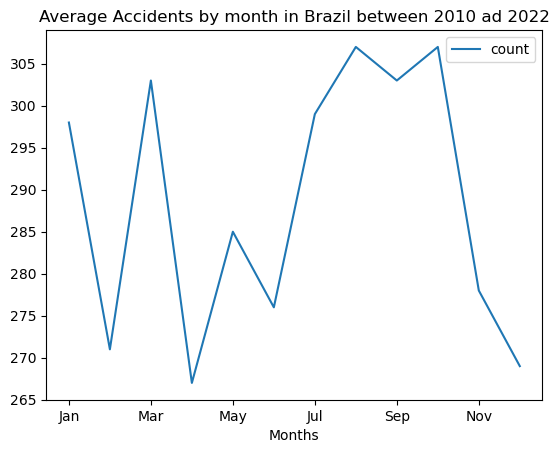

In [627]:
accidents_months.plot(kind = 'line', 
                      title = "Average Accidents by month in Brazil between 2010 ad 2022",
                      xlabel = 'Months')

Total Accidents by Year in Brazil from 2010-2022

In [622]:
accidents_year = work_accident.groupby(['YEAR'], as_index=False)['WORKACCIDENT'].agg('count')
accidents_year

,YEAR,WORKACCIDENT
0,2010,3494
1,2011,3668
2,2012,3740
3,2013,3860
4,2014,3607
5,2015,3238
6,2016,3137
7,2017,3211
8,2018,3203
9,2019,3486


<Axes: title={'center': 'Total Accidents by Year in Brazil between 2010 and 2022'}, xlabel='YEAR'>

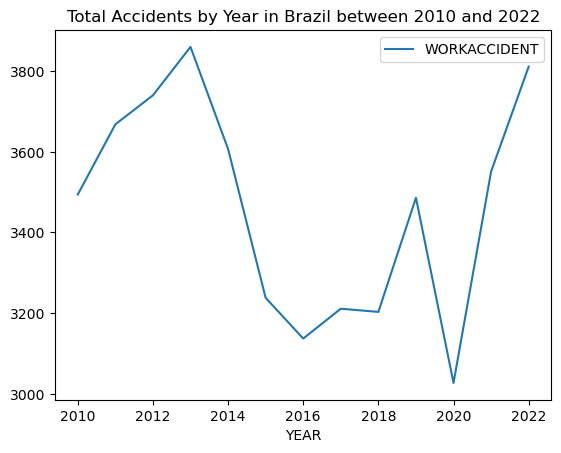

In [625]:
accidents_year.plot(kind='line', 
                    title = 'Total Accidents by Year in Brazil between 2010 and 2022',
                     x='YEAR',
                     y='WORKACCIDENT')

Percentage variation of Accidents by Year in Brazil from 2010-2022

In [628]:
percentage_variation_year = accidents_year
percentage_variation_year['WORKACCIDENT'] = accidents_year['WORKACCIDENT'].pct_change().mul(100)
percentage_variation_year

,YEAR,WORKACCIDENT
0,2010,NaN
1,2011,4.979966
2,2012,1.962923
3,2013,3.208556
4,2014,-6.554404
5,2015,-10.230108
6,2016,-3.119209
7,2017,2.358942
8,2018,-0.249144
9,2019,8.835467


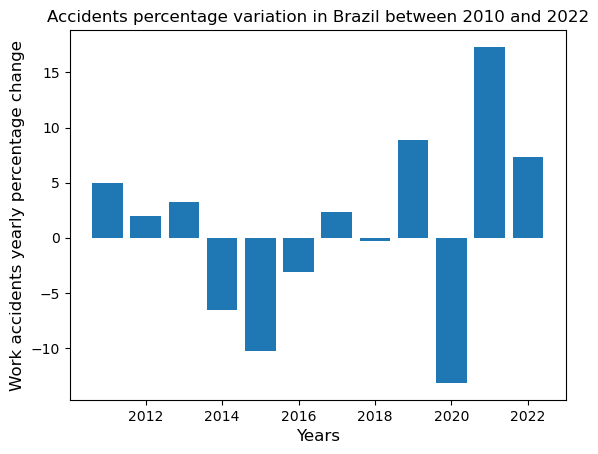

In [630]:
plt.xlabel('Years', fontsize=12)
plt.ylabel('Work accidents yearly percentage change', fontsize =12)
plt.bar(percentage_variation_year['YEAR'], percentage_variation_year['WORKACCIDENT'])
plt.title('Accidents percentage variation in Brazil between 2010 and 2022')
plt.show()

### Accidents by State

State accident rate per 100 thousand inhabitants per State in Brazil from 2010-2022

In [631]:
accidents_state = work_accident['STATE'].value_counts()
state_population = work_accident.drop_duplicates(subset="STATE").set_index("STATE")["POPULATION"]
accident_rate_per_100k = (accidents_state/state_population)*100000
accident_rate_per_100k = accident_rate_per_100k.sort_values(ascending=False)

<Axes: title={'center': 'Brazilian States accident rate per 100k people between 2010 and 2022'}, ylabel='STATE'>

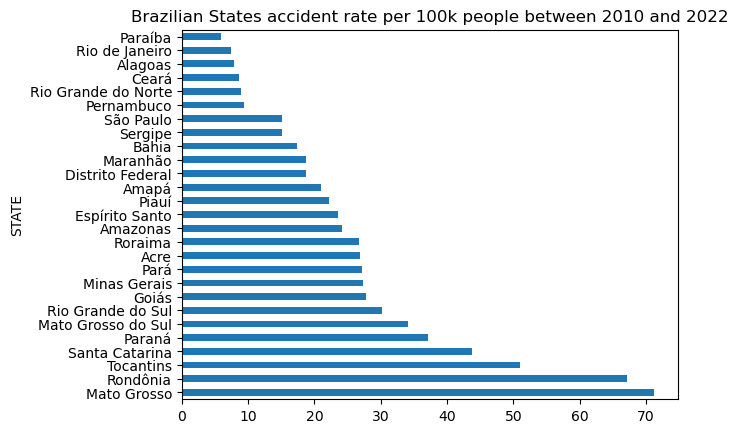

In [634]:
accident_rate_per_100k.plot(kind='barh', 
                            title = 'Brazilian States accident rate per 100k people between 2010 and 2022')

Total Accidents by State in Brazil from 2010-2022

<Axes: title={'center': 'Total Accidents by State in Brazil between 2010 and 2022'}, ylabel='STATE'>

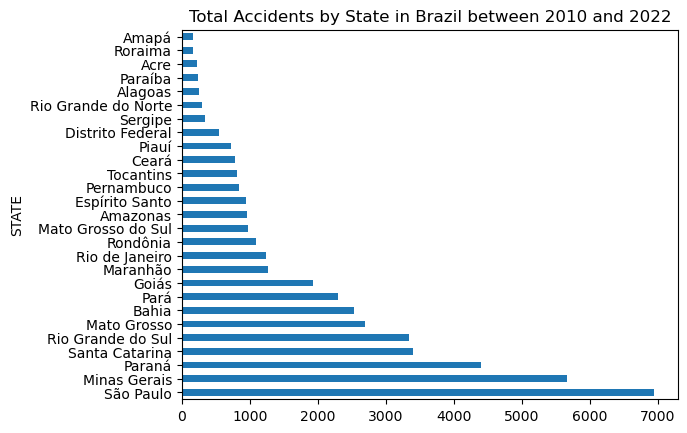

In [635]:
work_accident['STATE'].value_counts().plot(kind='barh', title='Total Accidents by State in Brazil between 2010 and 2022')

### Evaluating Profession, Gender and Age

In [ ]:
accidents_profession_year = work_accident.groupby(['YEAR','PROFESSION'], as_index=False)['WORKACCIDENT'].agg('count')
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(accidents_profession_year.sort_values(['YEAR','WORKACCIDENT'], ascending=False))

Checking Professions and Causes that are most common in accidents in Brazil from 2010-2022

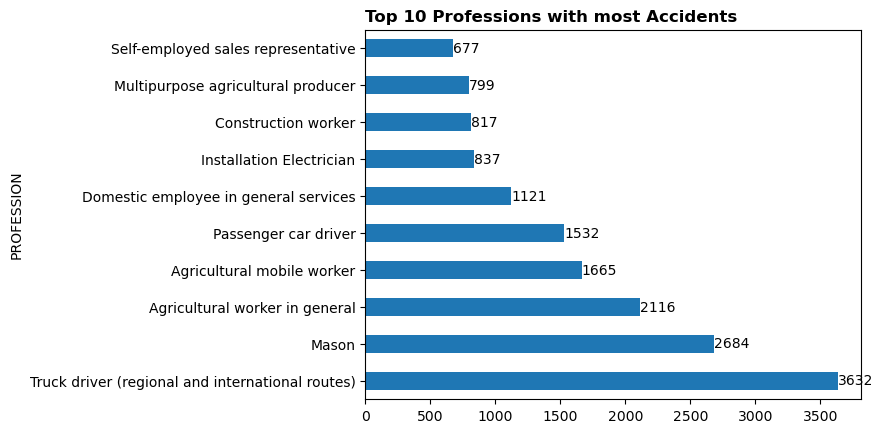

In [559]:
accidents_profession = work_accident.groupby(['PROFESSION'])['WORKACCIDENT'].agg('count').nlargest(10)
ax = accidents_profession.plot(kind='barh')
ax.bar_label(ax.containers[0])
ax.set_title('Top 10 Professions with most Accidents', loc='left', fontweight = 'bold')
plt.show()

In [560]:
accident_code = work_accident.groupby(['ACCIDENT_CODE', 'ACCIDENT_DESCRIPTION'], observed=True)['WORKACCIDENT'].agg(['count'])
accident_code['count'] = accident_code['count'].apply(lambda x: int(x))
accident_code['count'].nlargest(15)

ACCIDENT_CODE  ACCIDENT_DESCRIPTION                                                                                                                                    
782510         Occupant of a Heavy Haul Vehicle Traumatized in a Non-Collision Transport Accident - Driver [Driver] Traumatized in a Road Traffic Accident                 567
               Occupant of a heavy transport vehicle injured in collision with another heavy transport vehicle or a bus - driver [driver] injured in a traffic accident    466
               Person injured in a road traffic accident with an unspecified motor vehicle                                                                                 312
               Occupant [any] of an automobile [car], traumatized in an unspecified traffic accident                                                                       236
715210         Falling to or from buildings or other structures - location unspecified                                              

Professions and Causes with most accidents for **Females**

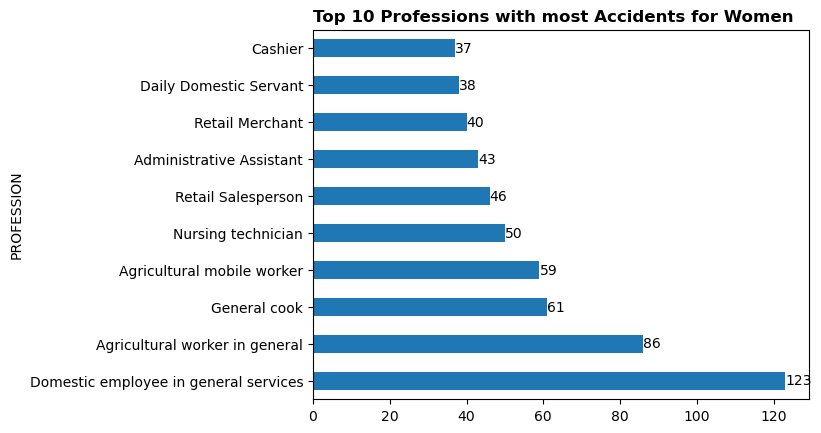

In [561]:
accidents_women = work_accident.query('SEX == "Female"').groupby(['PROFESSION'])['WORKACCIDENT'].agg('count').nlargest(10)
ax = accidents_women.plot(kind='barh')
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_title('Top 10 Professions with most Accidents for Women', loc='left', fontweight = 'bold')
plt.show()

In [562]:
accident_code = work_accident.query('SEX == "Female"').groupby(['ACCIDENT_CODE', 'ACCIDENT_DESCRIPTION'], observed=True)['WORKACCIDENT'].agg(['count'])
accident_code['count'] = accident_code['count'].apply(lambda x: int(x))
accident_code['count'].nlargest(15)

ACCIDENT_CODE  ACCIDENT_DESCRIPTION                                                                                                                        
512105         Motorcyclist injured in collision with a car, pick-up truck or pickup truck - driver injured in a traffic accident                              8
               Motorcyclist injured in collision with an automobile [car], pick up or pickup truck - passenger traumatized in a traffic accident               7
               Person injured in a road traffic accident with an unspecified motor vehicle                                                                     7
622020         Exposure to unspecified electrical current - residence                                                                                          6
411005         Motorcyclist injured in collision with a car, pick-up truck or pickup truck - driver injured in a traffic accident                              5
411010         Motorcyclist injured in 

Professions and Causes with most accidents for **Males**

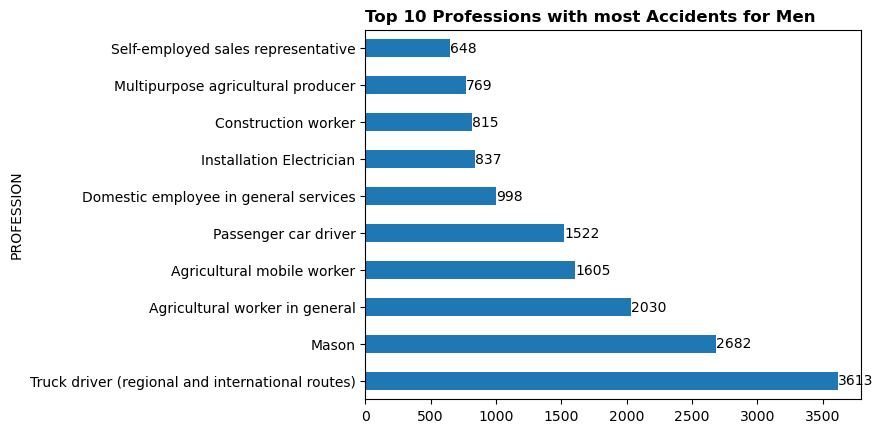

In [563]:
accidents_men = work_accident.query('SEX == "Male"').groupby(['PROFESSION'])['WORKACCIDENT'].agg('count').nlargest(10)
accidents_men.plot(kind='barh')
ax = accidents_men.plot(kind='barh')
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_title('Top 10 Professions with most Accidents for Men', loc='left', fontweight = 'bold')
plt.show()

In [564]:
accident_code = work_accident.query('SEX == "Male"').groupby(['ACCIDENT_CODE', 'ACCIDENT_DESCRIPTION'], observed=True)['WORKACCIDENT'].agg(['count'])
accident_code['count'] = accident_code['count'].apply(lambda x: int(x))
accident_code['count'].nlargest(15)

ACCIDENT_CODE  ACCIDENT_DESCRIPTION                                                                                                                                    
782510         Occupant of a Heavy Haul Vehicle Traumatized in a Non-Collision Transport Accident - Driver [Driver] Traumatized in a Road Traffic Accident                 562
               Occupant of a heavy transport vehicle injured in collision with another heavy transport vehicle or a bus - driver [driver] injured in a traffic accident    465
               Person injured in a road traffic accident with an unspecified motor vehicle                                                                                 309
               Occupant [any] of an automobile [car], traumatized in an unspecified traffic accident                                                                       235
715210         Falling to or from buildings or other structures - location unspecified                                              

### Percentage of accident by Age and Sex

<Axes: title={'center': 'Accidents by Age range'}>

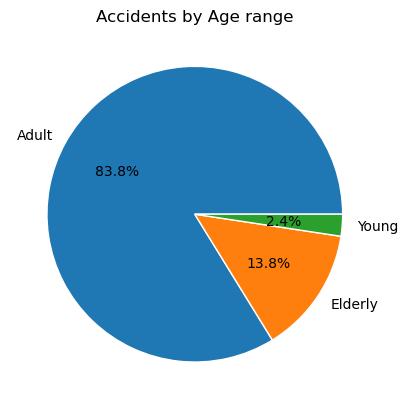

In [565]:
work_accident['AGE_RANGE'].value_counts().plot(kind='pie', 
                                                title='Accidents by Age range',
                                                ylabel='',
                                                autopct= '%1.1f%%',
                                                wedgeprops = {"linewidth": 1, "edgecolor": "white"},
                                                )

<Axes: title={'center': 'Accidents by sex'}>

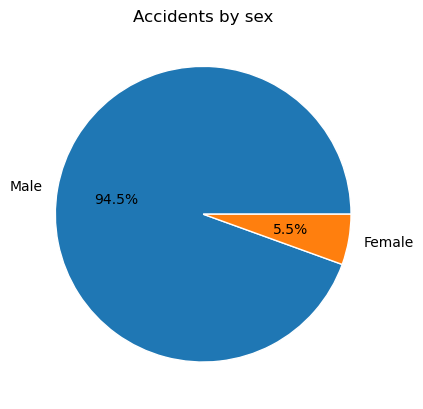

In [566]:
accidents_sex = work_accident.query('SEX in ["Male", "Female"]')
accidents_sex['SEX'].value_counts().plot(kind='pie', 
                                        title='Accidents by sex',
                                        ylabel='',
                                        autopct= '%1.1f%%',
                                        wedgeprops = {"linewidth": 1, "edgecolor": "white"}
                                        )

In [642]:
work_accident.head(10)

,AGE,SEX,WORKACCIDENT,YEAR,MONTH,MONTHNAME,SUBCAT,ACCIDENT_DESCRIPTION,ACCIDENT_CODE,PROFESSION,STATE,POPULATION,AGE_RANGE
0,27,Male,1,2010,3,Mar,W299,Contact with other hand items and household ap...,NaN,NaN,Acre,829780,Adult
1,42,Male,1,2010,4,Apr,W850,Exposure to electric power transmission lines ...,715615,Installation Electrician,Acre,829780,Adult
2,59,Male,1,2010,3,Mar,W139,Falling to or from buildings or other structur...,NaN,NaN,Acre,829780,Elderly
3,61,Female,1,2010,2,Feb,W209,"Impact caused by thrown, thrown or falling obj...",NaN,NaN,Acre,829780,Elderly
4,33,Male,1,2010,6,Jun,V899,Person injured in an accident with an unspecif...,NaN,NaN,Acre,829780,Adult
5,18,Male,1,2010,2,Feb,V845,Driver of a special motor vehicle for mainly a...,621005,Agricultural worker in general,Pernambuco,9051113,Young
6,21,Male,1,2010,1,Jan,V060,Pedestrian injured in collision with another n...,782310,Driver of a van or similar vehicle,Alagoas,3125254,Adult
7,40,Male,1,2010,4,Apr,W129,Falling onto or from a scaffold - location not...,715210,Mason,Alagoas,3125254,Adult
8,54,Male,1,2010,5,May,V952,Accident of another private-use fixed-wing air...,341120,Agricultural pilot,Alagoas,3125254,Adult
9,42,Male,1,2010,3,Mar,W205,"Impact caused by thrown, projected or falling ...",715210,Mason,São Paulo,46024937,Adult
